In [35]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [37]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

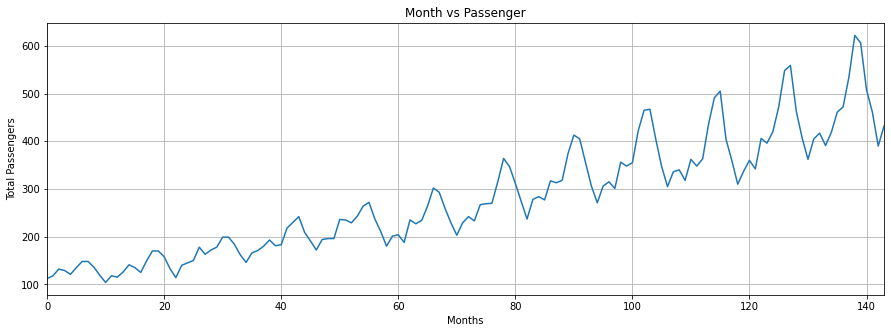

In [38]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers']);

In [39]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [40]:
all_data = flight_data['passengers'].values.astype(float)

In [41]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [42]:
print(len(train_data))
print(len(test_data))

132
12


In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [44]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [45]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [46]:
train_window = 12

In [47]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [48]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:2]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033]))]

In [49]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (
            torch.zeros(1, 1, self.hidden_layer_size),
            torch.zeros(1, 1, self.hidden_layer_size)
        )
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell
        )
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [50]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [51]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [52]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.11608399
epoch:  26 loss: 0.00883713
epoch:  51 loss: 0.00000001
epoch:  76 loss: 0.01083528
epoch: 101 loss: 0.02025076
epoch: 126 loss: 0.02258153
epoch: 149 loss: 0.0186640471


In [53]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [54]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [55]:
test_inputs[fut_pred:]

[1.8758620023727417,
 2.170377731323242,
 2.2543649673461914,
 2.287351608276367,
 2.303550958633423,
 2.3119781017303467,
 2.3165719509124756,
 2.319139003753662,
 2.320603370666504,
 2.3214313983917236,
 2.321774482727051,
 2.321658134460449]

In [56]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[758.25860554]
 [825.26093388]
 [844.36803007]
 [851.87249088]
 [855.55784309]
 [857.47501814]
 [858.52011883]
 [859.10412335]
 [859.43726683]
 [859.62564313]
 [859.70369482]
 [859.67722559]]


In [57]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


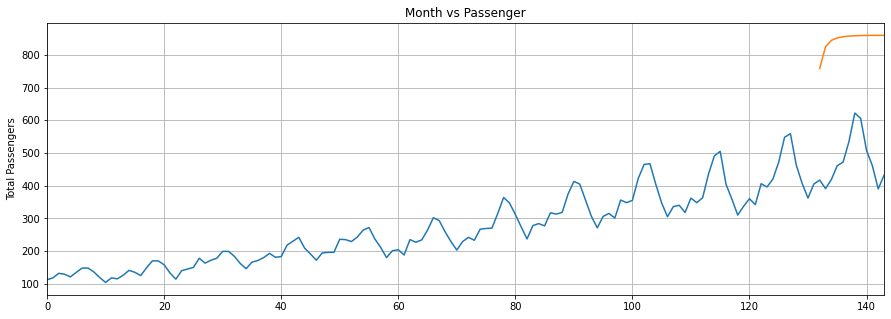

In [58]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

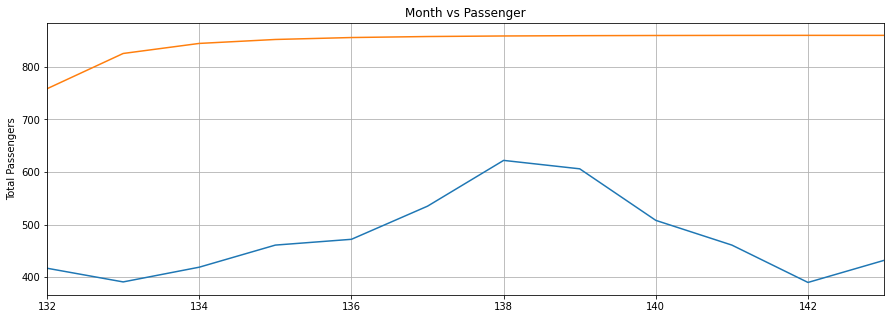

In [59]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()